In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import plotly.graph_objects as go
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from time import process_time 
from src.FunctionsProperties import *
import statsmodels.api as sm
from matplotlib.lines import Line2D
# plt.style.use('properties.mplstyle')

In [6]:
import matplotlib as mpl 
import numpy as np
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.optimize import curve_fit
from numpy.linalg import inv
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from matplotlib.colors import LinearSegmentedColormap

import os.path
dir = os.getcwd()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

GREY12 = "#1f1f1f"
plt.rcParams.update({"font.family": "Bell MT"})
plt.rcParams["text.color"] = GREY12
plt.rc("axes", unicode_minus=False)

def setlabel(ax, label, loc=2, borderpad=0.6, color = False, **kwargs):
    legend = ax.get_legend()
    if legend:
        ax.add_artist(legend)
    line, = ax.plot(np.NaN,np.NaN,color='none',label=label)
    label_legend = ax.legend(handles=[line],loc=loc,handlelength=0,handleheight=0,
                             handletextpad=0,borderaxespad=0,borderpad=borderpad,**kwargs)
    if color:
        for text in label_legend.get_texts():
            text.set_color("red")
    label_legend.remove()
    ax.add_artist(label_legend)
    line.remove()

In [188]:
make_results_folders()

In [9]:
df = pd.read_csv("../../data/all_data.txt", delimiter=' ')
df.head()

,N,dim,alpha_a,alpha_g,N_samples,short_mean,short_err,short_err_per,diameter_mean,diameter_err,diameter_err_per,ass_coeff_mean,ass_coeff_err,ass_coeff_err_per
0,5000,4,13.0,2.0,60952,12.712090,0.002927,0.023023,30.373523,0.009610,0.031639,-0.000145,0.000060,41.836001
1,5000,3,12.0,2.0,40912,13.292194,0.003339,0.025119,31.513981,0.011763,0.037325,-0.000052,0.000072,139.980567
2,5000,4,7.5,2.0,30996,11.503357,0.004193,0.036450,27.971222,0.012988,0.046434,-0.036049,0.000088,0.245332
3,5000,2,6.5,2.0,28277,13.366251,0.004089,0.030594,31.977897,0.014946,0.046737,-0.007291,0.000088,1.201787
4,10000,4,12.0,2.0,24310,13.786958,0.004756,0.034496,33.228754,0.015503,0.046654,0.000701,0.000074,10.546518


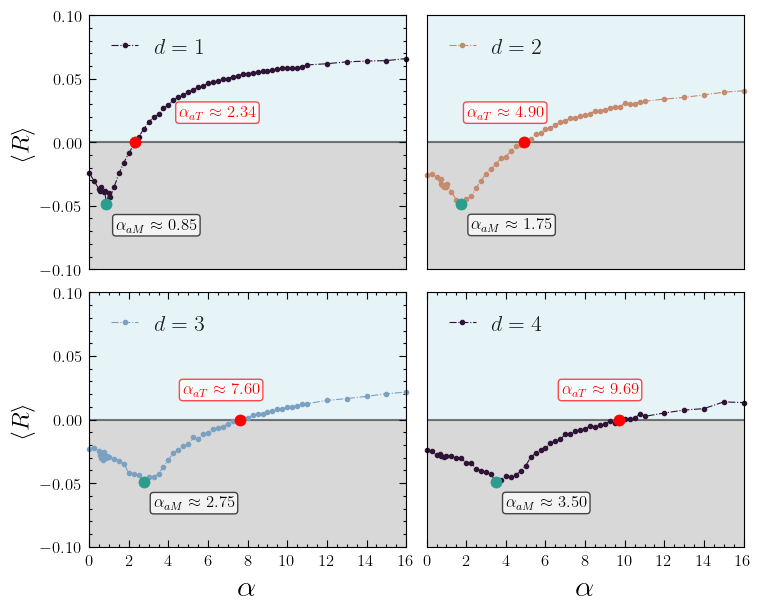

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(7.5, 6.), sharex=False, sharey=False, constrained_layout=True)
axs = axs.flatten()

dimensions = [1, 2, 3, 4]
norm = plt.Normalize(vmin=1, vmax=4)
cmap = cm.twilight_shifted.reversed()
n = 160000

for d, ax in zip(dimensions, axs):
    ax.axhline(y=0, color="black", linestyle="-", alpha = .5)
    ax.axhspan(0, 0.10, facecolor='lightblue', alpha = .3)
    ax.axhspan(-0.15, 0, facecolor='gray', alpha = .3)  # Rosa na parte inferior
    
    df_dim = df[(df['dim'] == d) & (df['N'] == n)]
    df_dim_alpha_a = df_dim[df_dim["alpha_g"] == 2]
    df_ord = df_dim_alpha_a.sort_values(by="alpha_a")
    df_ord = df_ord[df_ord["alpha_a"] <= 16.0]

    color = cmap(norm(d))
    ax.plot(df_ord['alpha_a'], df_ord['ass_coeff_mean'], 'o-.', ms = 3, lw = .8, color = color, clip_on=False,
                label=r'$d = %d$' % d)
    # adicinando marcadores no ponto de minino e transição
    min_row = df_ord.loc[df_ord['ass_coeff_mean'].idxmin()]
    alpha_min = min_row['alpha_a']
    value_min = min_row['ass_coeff_mean']
    # ax.plot(alpha_min, value_min, 'x', markersize=14, color='black')
    ax.plot(alpha_min, value_min, marker='o', markersize = 8, color='#2a9d8f', markeredgewidth=.5)
    ax.text(min(alpha_min + 0.5, 14.5), max(value_min - 0.02, -0.09),
            r"$\alpha_{aM} \approx %.2lf$" % alpha_min,
            fontsize=12, color='black', weight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.7))
    # transition
    # x, y = df_ord['alpha_a'], df_ord['ass_coeff_mean']
    # mask_red = y > 0
    # x, y = list(x[mask_red])[0], list(y[mask_red])[0]
    x, y = find_intersection(df_ord['alpha_a'].values, df_ord['ass_coeff_mean'].values)
    ax.plot(x, y, marker='o', markersize = 8, color='red', markeredgewidth=.5)
    ax.text(x + 1 if d != 1 else x + 2.2, y + .02,
            r"$\alpha_{aT} \approx %.2f$" % x,
            fontsize=12, color='red',
            bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2', alpha=0.7),
            ha='right' if d != 1 else 'left')

for ax in axs:
    ax.set_xlim([0, 16])
    ax.set_ylim([-.10, .10])
    ax.set_xticks(np.arange(0, 18, 2))
    # ax.set_ylim([0, 0.3])
    if ax in [axs[0], axs[2]]:
        ax.set_ylabel(r"$\langle R \rangle$", fontsize = 18)
    else:
        ax.set_yticks([])
    if ax in [axs[2], axs[3]]:
        ax.set_xlabel(r'$\alpha$', fontsize=22)
    else:
        ax.set_xticks([])
    
    # ax.set_yscale('log')
    ax.minorticks_on()
    ax.tick_params(axis='both', labelsize=12, length=3, width=1., colors='black', pad=5,
                   labelleft=True, top=True, bottom=True, left=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', length=5, width=.8, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=2, width=.8, colors='black', top=True, right=True)
    
    for spine in ax.spines.values():
        spine.set_linewidth(.8)

    ax.legend(numpoints = 1, borderpad = .5, handlelength = 1.2, handletextpad = .7, labelspacing = 0.3, 
              loc = 2, fancybox = True, framealpha = 0, shadow = False, facecolor = "white", 
              fontsize = 16, ncol = 1)

# plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.9])
# plt.savefig('img/kleinberg_network/average_number_of_long_range_edges.pdf', bbox_inches='tight')
plt.show()

In [12]:
def fit_alpha_a_models(N_values, alpha_a_values):
    """
    Ajusta três modelos assintóticos para estimar alpha_a^∞ em função de N:

    Modelos:
      1. Power Law:
         αₐ(N) = αₐ^∞ + C / N^p
      2. Shifted Power Law:
         αₐ(N) = αₐ^∞ + A / (N + N₀)^p
      3. Logarithmic Correction:
         αₐ(N) = αₐ^∞ + A / (log(N))^p

    Retorna:
      Um dicionário com os resultados para cada modelo, incluindo:
        - 'params': parâmetros ajustados
        - 'errors': erros dos parâmetros
        - 'R2': coeficiente de determinação
        - 'AIC': Akaike Information Criterion
        - 'BIC': Bayesian Information Criterion
        - 'N_fit': valores densos de N
        - 'alpha_fit': valores ajustados
        - 'function': função do modelo
    """
    def model_exp(N, alpha_inf, C, p):
        return alpha_inf + C * np.exp(-N**p)
        
    def model_power(N, alpha_inf, C, p):
        return alpha_inf + C / (N**p)

    def model_shifted(N, alpha_inf, A, N0, p):
        with np.errstate(divide='ignore', invalid='ignore'):
            result = np.empty_like(N, dtype=np.float64)
            valid = (N + N0) > 0
            result[~valid] = np.nan
            result[valid] = alpha_inf + A / ((N[valid] + N0)**p)
            return result

    def model_log(N, alpha_inf, A, p):
        with np.errstate(divide='ignore', invalid='ignore'):
            result = np.empty_like(N, dtype=np.float64)
            valid = np.log(N) > 0
            result[~valid] = np.nan
            result[valid] = alpha_inf + A / (np.log(N[valid])**p)
            return result
            
    N_s = np.array([20000, 3200, 700, 500, 200, 30, 15])  # número de amostras por ponto
    N_values = np.array(N_values)
    standard_error = 1 / np.sqrt(N_values*N_s)
    
    models = {
        "power": {
            "func": model_power,
            "p0": [np.min(alpha_a_values), 1e5, 1],
            "bounds": (-np.inf, np.inf),
            "k": 3
        },
        "exp": {
            "func": model_exp,
            "p0": [2., 100, .5],
            # "bounds": (-np.inf, np.inf),
            "k": 3
        },
        "shifted": {
            "func": model_shifted,
            "p0": [np.min(alpha_a_values), 1e5, 1e3, 1],
            "bounds": ([0, 0, 1e-5, 0], [np.inf, np.inf, np.inf, np.inf]),
            "k": 4
        },
        "log": {
            "func": model_log,
            "p0": [np.min(alpha_a_values), 1e5, 1],
            "bounds": (-np.inf, np.inf),
            "k": 3
        }
    }

    results = {}
    N_fit = np.linspace(np.min(N_values), np.max(N_values)*1., 100)

    for name, model in models.items():
        try:
            popt, pcov = curve_fit(model["func"], N_values, alpha_a_values, p0 = model["p0"],
                       absolute_sigma = True, sigma = standard_error, method='lm', maxfev=10000)
            perr = np.sqrt(np.diag(pcov))

            alpha_pred = model["func"](N_values, *popt)
            ss_res = np.nansum((alpha_a_values - alpha_pred)**2)
            ss_tot = np.nansum((alpha_a_values - np.nanmean(alpha_a_values))**2)
            R2 = 1 - ss_res / ss_tot

            AIC = len(N_values) * np.log(ss_res / len(N_values)) + 2 * model["k"]
            BIC = len(N_values) * np.log(ss_res / len(N_values)) + model["k"] * np.log(len(N_values))

            alpha_fit = model["func"](N_fit, *popt)

            results[name] = {
                "params": popt,
                "errors": perr,
                "R2": R2,
                "AIC": AIC,
                "BIC": BIC,
                "N_fit": N_fit,
                "alpha_fit": alpha_fit,
                "function": model["func"]
            }
        except Exception as e:
            results[name] = {"error": str(e)}
    
    return results

def round_value_and_error(value, error):
    """
    Arredonda o valor e o erro seguindo notação científica padrão:
    - Erro com 1 dígito significativo (ou 2 se começar com 1).
    - Valor arredondado para a mesma precisão decimal do erro.
    Retorna string: "valor ± erro"
    """
    if error == 0 or np.isnan(error):
        return f"{value:.4f} $±$ {error:.4f}"

    # Dígito mais significativo do erro
    exponent = int(np.floor(np.log10(abs(error))))
    mantissa = error / 10**exponent

    # Arredonda erro para 1 ou 2 dígitos significativos
    if mantissa < 1.5:
        sig_figs = 2
    else:
        sig_figs = 1

    rounded_error = round(error, -exponent + sig_figs - 1)

    # Número de casas decimais para o valor central
    decimals = max(-int(np.floor(np.log10(rounded_error))), 0)
    rounded_value = round(value, decimals)

    fmt = f".{decimals}f"
    return f"{format(rounded_value, fmt)} $±$ {format(rounded_error, fmt)}"


In [13]:
N = [5000, 10000, 20000, 40000, 80000, 160000, 320000]
parms_intercept = {"N":[], "dim":[], "alpha_intercept":[]}
dimensions = [1,2,3,4]

for dim in dimensions:
    for i in range(len(N)):
        # Filtra o DataFrame para a dimensão e valor de N desejados
        df_dim = df[(df['dim'] == dim) & (df['N'] == N[i]) & (df["alpha_g"]==2.0)]
        
        df_ord = df_dim.sort_values(by="alpha_a")
        
        x = df_ord['alpha_a'].values
        y = df_ord['ass_coeff_mean'].values
        
        x_int, y_int = find_intersection(x, y)
        
        parms_intercept["N"].append(N[i])
        parms_intercept["dim"].append(int(dim))
        parms_intercept["alpha_intercept"].append(float(x_int))
        
df_int = pd.DataFrame(data=parms_intercept)

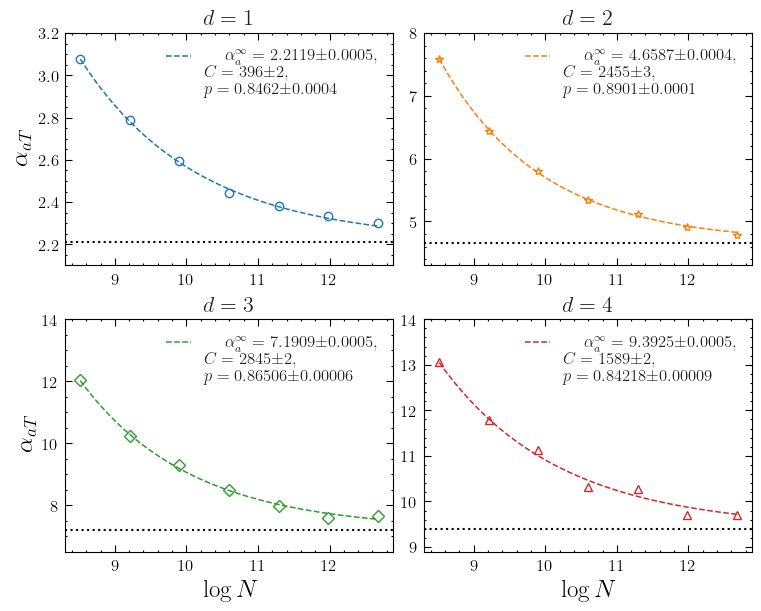

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(7.5, 6.), sharex=False, sharey=False, constrained_layout=True)
axs = axs.flatten()

dimensions = [1, 2, 3, 4]
norm = plt.Normalize(vmin=0, vmax=5)
cmap = cm.twilight_shifted.reversed()
N = np.array([5000, 10000, 20000, 40000, 80000, 160000, 320000])
N_s = np.array([20000, 3200, 700, 500, 200, 30, 15])

markers = {1: "o", 2: "*", 3: "D", 4: "^"}
colors = {1: "#1f77b4", 2: "#ff7f0e", 3: "#2ca02c", 4:"#d62728"}
y_limits = {1: [2.1, 3.2], 2: [4.3, 8.0], 3: [6.5, 14.0], 4:[8.9, 14.0]}

for d, ax in zip(dimensions, axs):
    color = cmap(norm(d))
    
    # Filtra os dados para a dimensão atual
    df_d = df_int[df_int["dim"] == d]
    N_vals = df_d["N"].values
    alpha_vals = df_d["alpha_intercept"].values
    N_vals = np.log(np.array(N_vals))

    nvalues, alpha_inf = N_vals, alpha_vals
    ax.plot(nvalues, alpha_inf, marker=markers[d],
            color='none', markeredgecolor=colors[d], ms = 6)
    
    def model_exp(x, alpha_inf, A, p):
        return alpha_inf + A * np.exp(-x**p)
    # dar para baixar o error inserindo o desvio padrão no fitting
    initial_guess = [2., 100, .5]
    standard_error = 1 / np.sqrt(N*N_s)
    popt, pcov = curve_fit(model_exp, nvalues, alpha_inf, p0 = initial_guess, #bounds=([2, 10, 10], [2.5, 1000, 1000]),
                           absolute_sigma = True, sigma = standard_error, method='lm', maxfev=10000)
    
    xe = np.linspace(np.min(nvalues), np.max(nvalues), 100)
    y_fit = model_exp(xe, *popt)

    p = popt
    err = np.sqrt(np.diag(pcov))
    alpha_txt = round_value_and_error(p[0], err[0])
    C_txt     = round_value_and_error(p[1], err[1])
    p_txt     = round_value_and_error(p[2], err[2])
    special_label = rf"$\alpha_a^\infty = {alpha_txt},\\ C = {C_txt},\\ p = {p_txt}$"
    
    ax.plot(xe, y_fit, '--', linewidth=1.1, color=colors[d], label = special_label)
    ax.set_title(r"$d = %d$" % d, fontsize = 16)

    # Linha assintótica
    ax.axhline(y=p[0], color='black', linestyle=":", alpha = 1)
    ax.set_ylim(y_limits[d])
    
for ax in axs:
    # ax.set_xscale('log')
    # ax.set_xlim([min(nvalues), max(nvalues)])
    # ax.set_xticks(np.arange(0, 18, 2))
    if ax in [axs[0], axs[2]]:
        ax.set_ylabel(r"$\alpha_{aT}$", fontsize = 18)
    if ax in [axs[2], axs[3]]:
        ax.set_xlabel(r'$\log{N}$', fontsize=18)
    # else:
    #     ax.set_xticks([])
    
    ax.minorticks_on()
    ax.tick_params(axis='both', labelsize=12, length=3, width=1., colors='black', pad=5,
                   labelleft=True, top=True, bottom=True, left=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', length=5, width=.8, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=1.5, width=.8, colors='black', top=True, right=True)
    
    for spine in ax.spines.values():
        spine.set_linewidth(.8)

    ax.legend(numpoints = 1, borderpad = .5, handlelength = 1.5, handletextpad = .7, labelspacing = 0.3, 
              loc = 1, fancybox = True, framealpha = 0, shadow = False, facecolor = "white", 
              fontsize = 12, ncol = 1)

plt.savefig('img/alpha_transition_fitting_2.pdf', bbox_inches='tight')
plt.show()

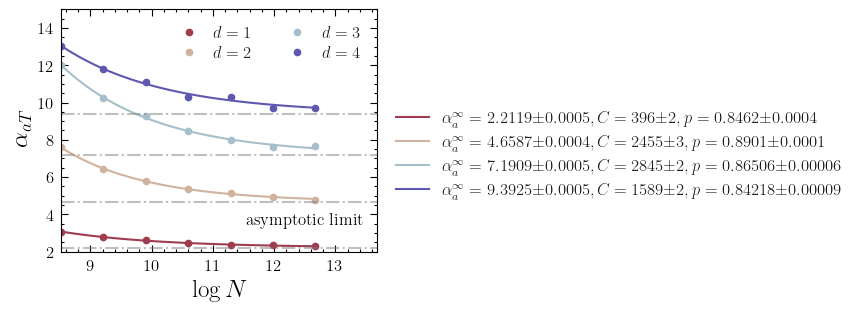

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(3.75, 3), sharex=True, sharey=False, constrained_layout=True)
# axs = axs.flatten()

dimensions = [1, 2, 3, 4]
norm = plt.Normalize(vmin=0, vmax=5)
cmap = cm.twilight_shifted.reversed()
N = np.array([5000, 10000, 20000, 40000, 80000, 160000, 320000])
N_s = np.array([20000, 3200, 700, 500, 200, 30, 15])

special_label = {}
alpha_infs = {}
for d in dimensions:
    color = cmap(norm(d))
    
    # Filtra os dados para a dimensão atual
    df_d = df_int[df_int["dim"] == d]
    N_vals = df_d["N"].values
    alpha_vals = df_d["alpha_intercept"].values
    N_vals = np.log(np.array(N_vals))

    nvalues, alpha_inf = N_vals, alpha_vals
    # ax.plot(nvalues, alpha_inf, 'o', color = color, ms = 5)
    
    def model_exp(x, alpha_inf, A, p):
        return alpha_inf + A * np.exp(-x**p)
    # dar para baixar o error inserindo o desvio padrão no fitting
    initial_guess = [2., 100, .5]
    standard_error = 1 / np.sqrt(N*N_s)
    popt, pcov = curve_fit(model_exp, nvalues, alpha_inf, p0 = initial_guess, #bounds=([2, 10, 10], [2.5, 1000, 1000]),
                           absolute_sigma = True, sigma = standard_error, method='lm', maxfev=10000)
    
    xe = np.linspace(np.min(nvalues), np.max(nvalues), 100)
    y_fit = model_exp(xe, *popt)

    p = popt
    err = np.sqrt(np.diag(pcov))
    alpha_txt = round_value_and_error(p[0], err[0])
    C_txt     = round_value_and_error(p[1], err[1])
    p_txt     = round_value_and_error(p[2], err[2])
    special_label[d] = rf"$\alpha_a^\infty = {alpha_txt}, C = {C_txt}, p = {p_txt}$"
    
    ax.plot(xe, y_fit, '-', linewidth=1.5, color=color)#, label = special_label)

    # Linha assintótica
    alpha_infs[d] = p[0]
for d in dimensions:
    color = cmap(norm(d))
    
    # Filtra os dados para a dimensão atual
    df_d = df_int[df_int["dim"] == d]
    N_vals = df_d["N"].values
    alpha_vals = df_d["alpha_intercept"].values
    N_vals = np.log(np.array(N_vals))

    nvalues, alpha_inf = N_vals, alpha_vals
    ax.plot(nvalues, alpha_inf, 'o', color = color, ms = 4.5, label = r'$d = %d$' % d)
    # Linha assintótica
    ax.axhline(y=alpha_infs[d], color='gray', linestyle="-.", alpha = .5)#, label=r"asymptotic limit")
    # ax.set_ylim([alpha_inf - .05 if d == 1 else alpha_inf - .3, max(alpha_vals) + .05*max(alpha_vals)])
    
# ax.set_xscale('log')
ax.set_xlim([min(N_vals), max(N_vals) + 1])
ax.set_ylim([2, 15])
# ax.set_xticks(np.arange(0, 18, 2))
ax.set_ylabel(r"$\alpha_{aT}$", fontsize = 18)
ax.set_xlabel(r'$\log{N}$', fontsize=18)


ax.minorticks_on()
ax.tick_params(axis='both', labelsize=12, length=3, width=1., colors='black', pad=5,
               labelleft=True, top=True, bottom=True, left=True, right=True)
ax.tick_params(axis='both', which='major', direction='in', length=5, width=.8, colors='black')
ax.tick_params(axis='both', which='minor', direction='in', length=2, width=.8, colors='black', top=True, right=True)

for spine in ax.spines.values():
    spine.set_linewidth(.8)

ax.text(12.5, 3.4, f"asymptotic limit", fontsize=12, color='black', 
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.2', alpha=0.7), ha='center')

ax.legend(numpoints = 1, borderpad = .5, handlelength = 1.5, handletextpad = .7, labelspacing = 0.3, 
          loc = 1, fancybox = True, framealpha = 0, shadow = False, facecolor = "white", 
          fontsize = 12, ncol = 2, bbox_to_anchor=[1., 1.])
fig.legend([special_label[dim] for dim in dimensions], prop={"size": 12}, 
           fancybox=True, framealpha=0.0, loc='center left', bbox_to_anchor=(1, 0.5))

# plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.9])
# plt.savefig('img/alpha_transition_fitting.pdf', bbox_inches='tight')
plt.show()

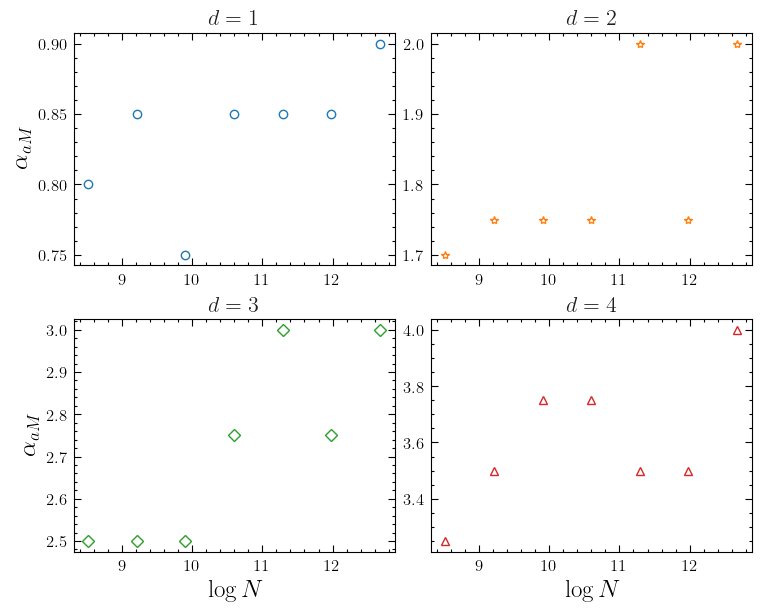

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(7.5, 6.), sharex=False, sharey=False, constrained_layout=True)
axs = axs.flatten()

dimensions = [1, 2, 3, 4]
norm = plt.Normalize(vmin=1, vmax=4)
cmap = cm.twilight_shifted.reversed()
N = np.array([5000, 10000, 20000, 40000, 80000, 160000, 320000])
N_s = np.array([20000, 3200, 700, 500, 200, 30, 15])

markers = {1: "o", 2: "*", 3: "D", 4: "^"}
colors = {1: "#1f77b4", 2: "#ff7f0e", 3: "#2ca02c", 4:"#d62728"}
y_limits = {1: [2.1, 3.2], 2: [4.3, 8.0], 3: [6.5, 14.0], 4:[8.9, 14.0]}

for d, ax in zip(dimensions, axs):
    alpha_min = []
    for n in N:
        df_dim = df[(df['dim'] == d) & (df['N'] == n)]
        df_dim_alpha_a = df_dim[df_dim["alpha_g"] == 2]
        df_ord = df_dim_alpha_a.sort_values(by="alpha_a")
        df_ord = df_ord[df_ord["alpha_a"] <= 16.0]
    
        # ponto de minino da assortatividade
        min_row = df_ord.loc[df_ord['ass_coeff_mean'].idxmin()]
        alpha_min.append(min_row['alpha_a'])

    N_vals = np.log(np.array(N))
    ax.plot(N_vals, alpha_min, marker=markers[d],
            color='none', markeredgecolor=colors[d], ms = 6)
    ax.set_title(r"$d = %d$" % d, fontsize = 16)
    

for ax in axs:
    if ax in [axs[0], axs[2]]:
        ax.set_ylabel(r"$\alpha_{aM}$", fontsize = 18)
    if ax in [axs[2], axs[3]]:
        ax.set_xlabel(r'$\log{N}$', fontsize=18)
    
    # ax.set_yscale('log')
    ax.minorticks_on()
    ax.tick_params(axis='both', labelsize=12, length=3, width=1., colors='black', pad=5,
                   labelleft=True, top=True, bottom=True, left=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', length=5, width=.8, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=2, width=.8, colors='black', top=True, right=True)
    
    for spine in ax.spines.values():
        spine.set_linewidth(.8)

    # ax.legend(numpoints = 1, borderpad = .5, handlelength = 1.2, handletextpad = .7, labelspacing = 0.3, 
    #           loc = 2, fancybox = True, framealpha = 0, shadow = False, facecolor = "white", 
    #           fontsize = 16, ncol = 1)

# plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.9])
# plt.savefig('img/kleinberg_network/average_number_of_long_range_edges.pdf', bbox_inches='tight')
plt.show()

AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.

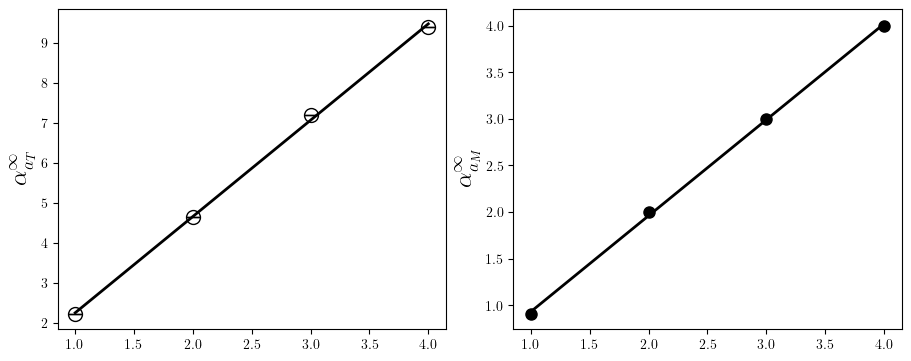

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5), sharex=True, sharey=False, constrained_layout=True)

#================== alpha transition ================
ax = axs[0]
# Parâmetros visuais
markersize = 10
dimensions = [1, 2, 3, 4]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

x = []
y = []
err_y = []
for d in dimensions:
    df_d = df_int[df_int["dim"] == d]
    N_vals = df_d["N"].values
    alpha_vals = df_d["alpha_intercept"].values
    N_vals = np.log(np.array(N_vals))

    nvalues, alpha_inf = N_vals, alpha_vals
    def model_exp(x, alpha_inf, A, p):
        return alpha_inf + A * np.exp(-x**p)

    initial_guess = [2., 100, .5]
    standard_error = 1 / np.sqrt(N*N_s)
    popt, pcov = curve_fit(model_exp, nvalues, alpha_inf, p0 = initial_guess,
                           absolute_sigma = True, sigma = standard_error, method='lm', maxfev=10000)

    x.append(d)
    y.append(popt[0])
    err_y.append(np.sqrt(np.diag(pcov))[0])

x = np.array(x)
y = np.array(y)
err_y = np.array(err_y)
# Plotando apenas os marcadores com barras de erro
ax.errorbar(x, y, yerr=err_y, fmt='o', markersize=markersize, markerfacecolor='none', color='black', linestyle='None', capsize=5)

# ax.plot(x, y, 'o', color = 'k', ms = 5)
def model_linear(x, a, b):
    return a * x + b
initial_guess = [1, .1]
popt, pcov = curve_fit(model_linear, x, y, p0 = initial_guess, method='lm', maxfev=10000)

xe = np.linspace(np.min(x), np.max(x), 100)
y_fit = model_linear(xe, *popt)
A, B = popt[0], popt[1]
A_err, B_err = np.sqrt(np.diag(pcov))[0], np.sqrt(np.diag(pcov))[1]
ax.plot(xe, y_fit, 'k', lw = 2, label=rf"$A = {A:.2f} \pm {A_err:.2f}$, $B = {B:.2f} \pm {B_err:.2f}$")

# Regressão linear
# y_fit = linear_regression(x, y, err_y, Parameter=False)
# A, B, A_err, B_err = linear_regression(x, y, err_y, Parameter=True)
# # Plotando a regressão linear como uma linha contínua
# ax.plot(x, y_fit, linestyle='-', linewidth=2, color='black', label=rf"$A = {A:.2f} \pm {A_err:.2f}$, $B = {B:.2f} \pm {B_err:.2f}$")

# =========== alpha_min usando o limite termodinamico, maior valor de N ===========
n = 320000
alpha_min = []
for d in dimensions:
    df_dim = df[(df['dim'] == d) & (df['N'] == n)]
    df_dim_alpha_a = df_dim[df_dim["alpha_g"] == 2]
    df_ord = df_dim_alpha_a.sort_values(by="alpha_a")
    df_ord = df_ord[df_ord["alpha_a"] <= 16.0]

    # ponto de minino da assortatividade
    min_row = df_ord.loc[df_ord['ass_coeff_mean'].idxmin()]
    alpha_min.append(min_row['alpha_a'])
    
axs[1].plot(dimensions, alpha_min, 'o', color = 'k', ms = 8)
def model_linear(x, a, b):
    return a * x + b
initial_guess = [1, .1]
popt, pcov = curve_fit(model_linear, dimensions, alpha_min, p0 = initial_guess, method='lm', maxfev=10000)
xe = np.linspace(np.min(dimensions), np.max(dimensions), 100)
y_fit = model_linear(xe, *popt)
A, B = popt[0], popt[1]
A_err, B_err = np.sqrt(np.diag(pcov))[0], np.sqrt(np.diag(pcov))[1]
axs[1].plot(xe, y_fit, 'k', lw = 2, label=rf"$A = {A:.2f} \pm {A_err:.2f}$, $B = {B:.2f} \pm {B_err:.2f}$")
    
axs[0].set_ylabel(r"$\alpha_{a_T}^{\infty}$", fontsize = 18)
axs[1].set_ylabel(r"$\alpha_{a_M}^{\infty}$", fontsize = 18)
setlabel(axs[1], r'$N = %d$' % n, loc=4, borderpad=0.6, fontsize = 14,
         fancybox = True, framealpha = 0, shadow = False, facecolor = "white")

for ax in axs:
    ax.set_xlabel(r'$d$', fontsize=18)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', labelsize=12, length=3, width=1., colors='black', pad=5,
                   labelleft=True, top=True, bottom=True, left=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', length=5, width=.8, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=2, width=.8, colors='black', top=True, right=True)
    
    for spine in ax.spines.values():
        spine.set_linewidth(.8)
    
    ax.legend(numpoints = 1, borderpad = .5, handlelength = 1.5, handletextpad = .7, labelspacing = 0.3, 
              loc = 2, fancybox = True, framealpha = 0, shadow = False, facecolor = "white", 
              fontsize = 12, ncol = 2)#, bbox_to_anchor=[1., 1.])

plt.tight_layout()
# plt.savefig('img/alpha_transition_linear.pdf', bbox_inches='tight')
plt.show()

### Para ajuster do modelo:

1. Indicar os parâmetros de entrada melhores, não variar entre $[-\infty, \infty]$
2. Entrar com sigma (uncertainty in ydata)
3. Os parâmetros estão altamente correlacionados, vemos isso pela matriz de covarianca

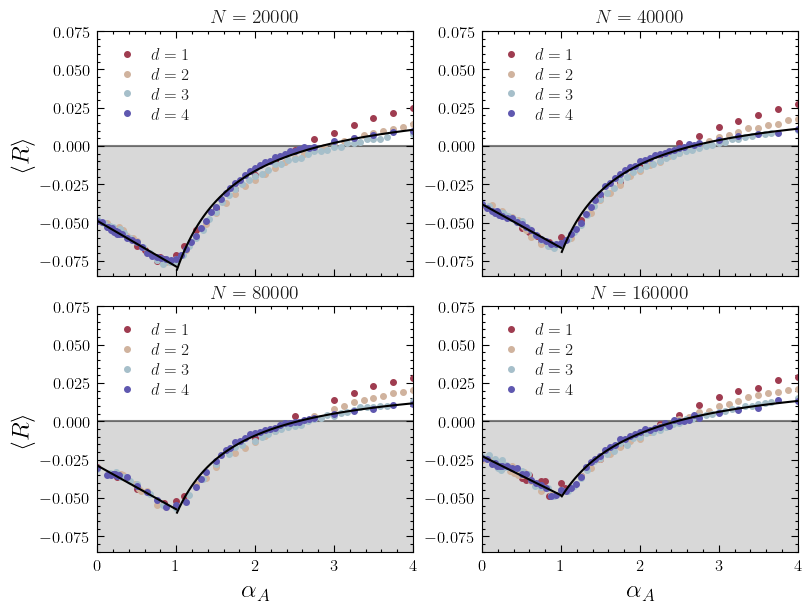

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6.), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()

norm = plt.Normalize(vmin=0, vmax=5)
cmap = cm.twilight_shifted.reversed()
N = [20000, 40000, 80000, 160000]#, 5000, 10000, 320000]

for ax, n in zip(axs, N):
    ax.set_title(r"$N = %d$" % n, fontsize = 14)
    ax.axhline(y=0, color="black", linestyle="-", alpha = .5)
    ax.axhspan(-0.085, 0, facecolor='gray', alpha = .3)  # Rosa na parte inferior
    
    for d in np.arange(1, 5):
        df_dim = df[(df['dim'] == d) & (df['N'] == n)]
        df_dim_alpha_a = df_dim[df_dim["alpha_g"] == 2]
        df_ord = df_dim_alpha_a.sort_values(by="alpha_a")
        # df_ord = df_ord[df_ord["alpha_a"] <= 16.0]
        
        x, y = np.array(df_ord['alpha_a']), np.array(df_ord['ass_coeff_mean'])
        x = x / d
        
        color = cmap(norm(d))
        ax.plot(x, y, 'o', color = color, ms = 4, label = r'$d = %d$' % d)
        #========== fitando cada lado da assortatividade, separadas pelo ponto de minino ===========
        if d == 4:
            x, y = np.array(x), np.array(y)
            mask = (x < 1)
            xl, yl = x[mask], y[mask]
            
            def lower(x, a, b):
                return (a - x) / b
            
            popt, pcov = curve_fit(lower, xl, yl, method='lm', maxfev=10000)
            xe = np.linspace(0,.9999, 100)
            y_fit = lower(xe, *popt)
            ax.plot(xe, y_fit, '-', linewidth=1.5, color='k')#, label = r'$(%.2lf -\alpha_A) / %.2lf$' % (popt[0], popt[1]))
            
            mask = (x >= 1)
            xr, yr = x[mask], y[mask]
            
            def upper(x, a, b, c):
                return a - b / (x + c)
            
            popt, pcov = curve_fit(upper, xr, yr, p0 = [1, 1, 1], method='lm', maxfev=10000)
            xe = np.linspace(1.01, 4, 100)
            y_fit = upper(xe, *popt)
            ax.plot(xe, y_fit, '-', linewidth=1.5, color='k')#, label = r'$( %.2lf - %.2lf) / (\alpha_A + %.2lf)$' % (popt[0], popt[1], popt[2]))
            # mask = (x == 1)
            # ax.plot([1], y[mask], 'o', color = 'red', ms = 6)
    
    ax.set_xlim([0, 4])
    ax.set_ylim([-.085, .075])
    # ax.set_xticks(np.arange(0, 18, 2))
    if ax in [axs[0], axs[2]]:
        ax.set_ylabel(r"$\langle R \rangle$", fontsize = 18)
    if ax in [axs[2], axs[3]]:
        ax.set_xlabel(r'$\alpha_A$', fontsize=18)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', labelsize=12, length=3, width=1., colors='black', pad=5,
                   labelleft=True, top=True, bottom=True, left=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', length=5, width=.8, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=2, width=.8, colors='black', top=True, right=True)
    
    for spine in ax.spines.values():
        spine.set_linewidth(.8)
    
    ax.legend(numpoints = 1, borderpad = .5, handlelength = 1.5, handletextpad = .7, labelspacing = 0.3, 
              loc = 2, fancybox = True, framealpha = 0, shadow = False, facecolor = "white", 
              fontsize = 12, ncol = 1)

# plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 1, 0.9])
# plt.savefig('img/kleinberg_network/average_number_of_long_range_edges.pdf', bbox_inches='tight')
plt.show()